In [20]:
import os
import logging
from pathlib import Path

from dotenv import dotenv_values
import pickle
import wandb
import numpy as np
import torch
import datasets
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from exrep.model import LocalRepresentationApproximator
from exrep.registry import load_data, save_data, load_model, load_tensor, get_artifact, save_tensor, load_entry

if 'notebooks' in os.getcwd():
    os.chdir("../")

local_config = dotenv_values(".env")
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

random_state = 42

run = wandb.init(
    project=local_config["WANDB_PROJECT"],
    config={
        "job_type": "attribution_downstream",
        "num_clusters": 160,
    },
    # reinit=True,
    # save_code=True,
)

device = "cuda:4"

In [21]:
run_cfg = wandb.Api().run("explain-representation/17466o8h").config
artifact = get_artifact(
    base_name="imagenet",
    phase="surrogate",
    identifier="mocov3-resnet50",
    wandb_run=run,
)
weights = torch.load(
    artifact.get_entry(f"explainer-{run.config.num_clusters}.pt").download(),
    device
)
model = LocalRepresentationApproximator(
    local_dim=weights['query_encoder.weight'].shape[1],
    repr_dim=weights['key_encoder.weight'].shape[1],
    output_dim=weights['query_encoder.weight'].shape[0],
    temperature=run_cfg['loss']['temp_student'],
    device=device,
)
model.load_state_dict(weights)

/tmp/ipykernel_3300021/1170966549.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(


<All keys matched successfully>

In [22]:
%load_ext autoreload
%autoreload 2

from scripts.train_surrogate import train_surrogate_experiment, load_imagenet
from exrep.viz import plot_dendrogram, get_cluster_children, viz_clusters, get_cluster_leaves

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
dataset_dict = load_imagenet(run, device, random_state)
xy_dataset = dataset_dict["combined_dataset"]
embeddings = dataset_dict["embeddings"]
encoding = dataset_dict["local-encoding"]

/blue/thai/hoangx/projects/explain-representation/exrep/registry.py:196: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(file_path, map_location=map_locati

In [24]:
train_labels = xy_dataset['train']['label']
train_encoding = xy_dataset['train']['inputs']
train_embeddings = xy_dataset['train']['targets']
test_labels = xy_dataset['test']['label']
test_encoding = xy_dataset['test']['inputs']
test_embeddings = xy_dataset['test']['targets'] 

with torch.inference_mode():
    surrogate_train_embeds = model.encode(query=train_encoding.to(device))
    surrogate_test_embeds = model.encode(query=test_encoding.to(device))

train_encoding.shape

torch.Size([1800, 153])

In [25]:
classifier = LogisticRegression(C=0.5, fit_intercept=False).fit(train_embeddings, train_labels)
train_original_logits = classifier.predict_log_proba(train_embeddings)
train_original_probs = classifier.predict_proba(train_embeddings)
test_original_logits = classifier.predict_log_proba(test_embeddings)
test_original_probs = classifier.predict_proba(test_embeddings)
classifier.score(train_embeddings, train_labels), classifier.score(test_embeddings, test_labels)

(0.9483333333333334, 0.785)

In [26]:
with torch.inference_mode():
    surrogate_prototypes = model.encode(key=torch.from_numpy(classifier.coef_).to(device, dtype=torch.float32), normalize=False)
    surrogate_train_logits = surrogate_train_embeds @ surrogate_prototypes.T / model.temperature
    surrogate_train_probs = torch.softmax(surrogate_train_embeds @ surrogate_prototypes.T / model.temperature, dim=1)
    kl_train_loss = torch.nn.functional.kl_div(
        torch.log_softmax(surrogate_train_logits, dim=1), 
        torch.from_numpy(train_original_logits).to(device),
        reduction='batchmean',
        log_target=True,
    )
    ce_train_loss = torch.nn.functional.cross_entropy(
        surrogate_train_logits,
        torch.from_numpy(train_original_probs).to(device),
    )

    surrogate_test_logits = surrogate_test_embeds @ surrogate_prototypes.T / model.temperature
    surrogate_test_probs = torch.softmax(surrogate_test_embeds @ surrogate_prototypes.T / model.temperature, dim=1)
    kl_loss = torch.nn.functional.kl_div(
        torch.log_softmax(surrogate_test_logits, dim=1), 
        torch.from_numpy(test_original_logits).to(device),
        reduction='batchmean',
        log_target=True,
    )
    ce_loss = torch.nn.functional.cross_entropy(
        surrogate_test_logits,
        torch.from_numpy(test_original_probs).to(device),
    )
kl_loss, ce_loss, kl_train_loss, ce_train_loss

(tensor(0.7579, device='cuda:4', dtype=torch.float64),
 tensor(2.3165, device='cuda:4', dtype=torch.float64),
 tensor(0.8339, device='cuda:4', dtype=torch.float64),
 tensor(2.2390, device='cuda:4', dtype=torch.float64))

In [27]:
def learn_bias(surrogate_logits, original_logits, n_iter=100, lr=0.2):
    bias = torch.randn(surrogate_logits.shape[1], device=surrogate_logits.device, requires_grad=True)
    optimizer = torch.optim.Adam([bias], lr=lr)
    surrogate_logits = torch.tensor(surrogate_logits, requires_grad=True)
    original_logits = torch.tensor(original_logits, requires_grad=True)
    for _ in range(n_iter):
        loss = torch.nn.functional.cross_entropy(
            surrogate_logits + bias,
            torch.softmax(original_logits, dim=1)
        )
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # logger.info(f"Loss: {loss.item()}")
    bias = bias - bias.min()
    return bias

b = learn_bias(surrogate_train_logits, torch.from_numpy(train_original_logits).to(device))

/tmp/ipykernel_3300021/2162876122.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  surrogate_logits = torch.tensor(surrogate_logits, requires_grad=True)
/tmp/ipykernel_3300021/2162876122.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  original_logits = torch.tensor(original_logits, requires_grad=True)


In [28]:
kl_train_loss_with_bias = torch.nn.functional.kl_div(
    torch.log_softmax(surrogate_train_logits + b, dim=1), 
    torch.from_numpy(train_original_logits).to(device),
    reduction='batchmean',
    log_target=True,
)
ce_train_loss_with_bias = torch.nn.functional.cross_entropy(
    surrogate_train_logits + b,
    torch.from_numpy(train_original_probs).to(device),
)
kl_test_loss_with_bias = torch.nn.functional.kl_div(
    torch.log_softmax(surrogate_test_logits + b, dim=1), 
    torch.from_numpy(test_original_logits).to(device),
    reduction='batchmean',
    log_target=True,
)
ce_test_loss_with_bias = torch.nn.functional.cross_entropy(
    surrogate_test_logits + b,
    torch.from_numpy(test_original_probs).to(device),
)
kl_test_loss_with_bias, ce_test_loss_with_bias, kl_train_loss_with_bias, ce_train_loss_with_bias, b

(tensor(0.7074, device='cuda:4', dtype=torch.float64, grad_fn=<DivBackward0>),
 tensor(2.2660, device='cuda:4', dtype=torch.float64, grad_fn=<DivBackward1>),
 tensor(0.7755, device='cuda:4', dtype=torch.float64, grad_fn=<DivBackward0>),
 tensor(2.1806, device='cuda:4', dtype=torch.float64, grad_fn=<DivBackward1>),
 tensor([0.2046, 0.5575, 0.6915, 0.8405, 1.0932, 1.2520, 1.1678, 0.3148, 0.0000,
         0.4192, 0.4835, 0.3439, 0.4767, 0.5965, 1.0834, 0.7150, 0.1294, 0.6401,
         0.4414, 0.0445], device='cuda:4', grad_fn=<SubBackward0>))

In [29]:
wandb.log({"ce_test_downstream": ce_test_loss_with_bias.item()})

In [ ]:
downstream_classifier = LogisticRegression().fit(train_encoding, train_labels)
downstream_classifier.score(train_encoding, train_labels), downstream_classifier.score(test_encoding, test_labels)



(0.8588888888888889, 0.82)

In [ ]:
# W_r is (n_output_dim, n_concepts)
# W_h is (n_classes, 
# z = W_r @ x + b_r
# y = W_h @ z + b_h

# y = W_h @ (W_r @ x + b_r) + b_h
# y = (W_h @ W_r) @ x + W_h @ b_r + b_h 

In [46]:
class_of_interest = 0
weight_matrix = (surrogate_prototypes @ weights['query_encoder.weight']).detach().cpu().numpy()
w = weight_matrix[class_of_interest]
w

array([-0.00750654,  0.18827158,  0.0825977 , -0.09313332, -0.1486488 ,
        0.18861797,  0.10312222, -0.05825114,  0.03321671,  0.18071505,
        0.31577113,  0.22268571, -0.06472655, -0.00114891, -0.00413281,
       -0.03167045, -0.01875549,  0.01314385, -0.02275135, -0.05588555,
       -0.03987815, -0.06011763, -0.11971533, -0.04144117, -0.04730426,
        0.00816663,  0.06624279,  0.02646448,  0.02392489,  0.06162746,
       -0.03533496, -0.05212297,  0.00439849, -0.05089075, -0.07168689,
       -0.08358577, -0.01543046,  0.01477541, -0.02528204,  0.00301183,
       -0.08312719,  0.00609009, -0.01232483,  0.00448225,  0.00630058,
       -0.04960679,  0.01286714,  0.01961364, -0.04945298,  0.06796314,
       -0.00060112,  0.01313794,  0.36092073,  0.01245663, -0.02899911,
        0.00602047,  0.0067529 ,  0.01931424,  0.00187607, -0.05092889,
        0.06534994, -0.01231031, -0.08798386, -0.09576164, -0.02124438,
        0.0376915 , -0.07088746,  0.02701864, -0.02695056,  0.00

In [47]:
np.round(w[np.argsort(w)[::-1]],3)

array([ 0.361,  0.316,  0.223,  0.189,  0.188,  0.181,  0.103,  0.083,
        0.068,  0.066,  0.065,  0.062,  0.038,  0.033,  0.027,  0.026,
        0.024,  0.024,  0.02 ,  0.019,  0.015,  0.013,  0.013,  0.013,
        0.012,  0.012,  0.008,  0.007,  0.006,  0.006,  0.006,  0.005,
        0.004,  0.004,  0.003,  0.002,  0.001, -0.001, -0.001, -0.004,
       -0.008, -0.012, -0.012, -0.015, -0.019, -0.021, -0.023, -0.023,
       -0.025, -0.025, -0.027, -0.029, -0.029, -0.03 , -0.032, -0.035,
       -0.039, -0.04 , -0.041, -0.047, -0.049, -0.05 , -0.051, -0.051,
       -0.052, -0.056, -0.058, -0.06 , -0.065, -0.071, -0.072, -0.083,
       -0.084, -0.088, -0.093, -0.096, -0.12 , -0.149], dtype=float32)

In [48]:
indices = np.argsort(w)[:-6:-1]
indices, w[indices]
# np.where(w[0] > 0)[0]

(array([52, 10, 11,  5,  1]),
 array([0.36092073, 0.31577113, 0.22268571, 0.18861797, 0.18827158],
       dtype=float32))

In [14]:
clustering_pkl = load_entry(
    artifact_name="imagenet-1k-first-20-take-2000_clustering",
    file_name="agglomerative.pkl",
    wandb_run=run,
)
crops_dataset = datasets.load_from_disk(get_artifact(
    base_name="imagenet",
    phase="crops",
    wandb_run=run,
).download())
images_dataset = datasets.load_from_disk(get_artifact(
    base_name="imagenet",
    phase="images",
    wandb_run=run,
).download())
with open(clustering_pkl, "rb") as f:
    clustering = pickle.load(f)
dendograms = {}

wandb: Downloading large artifact imagenet-1k-first-20-take-2000_crops:latest, 2150.68MB. 7 files... 
wandb:   7 of 7 files downloaded.  
Done. 0:0:1.1
wandb: Downloading large artifact imagenet-1k-first-20-take-2000_images:latest, 230.91MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.6


In [49]:
import pandas as pd

def load_label_encoder(n_clusters):
    label_encoder_pkl = load_entry(
        f"label-encoder-{n_clusters}.pkl",
        base_name="imagenet",
        phase="local-encoding",
        identifier="agglomerative",
        wandb_run=run,
    )
    with open(label_encoder_pkl, "rb") as f:
        label_encoder = pickle.load(f)
    return label_encoder

In [50]:
label_encoder = load_label_encoder(run.config.num_clusters)
cluster_ids = label_encoder.inverse_transform(indices)
cluster_labels = get_cluster_leaves(cluster_ids, clustering)[0]
cluster_ids

array([20471, 20338, 20341, 20241, 19723])

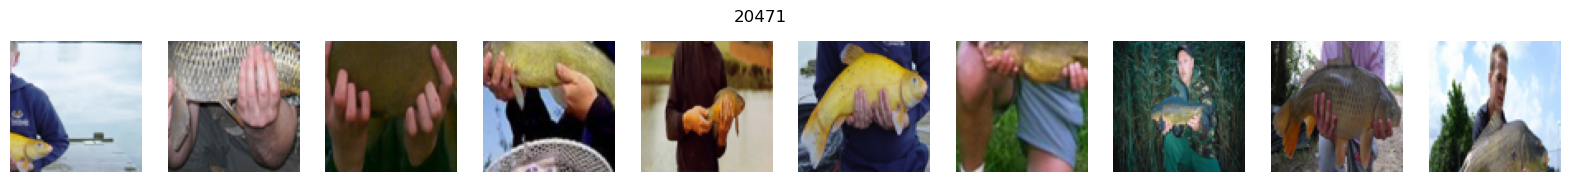

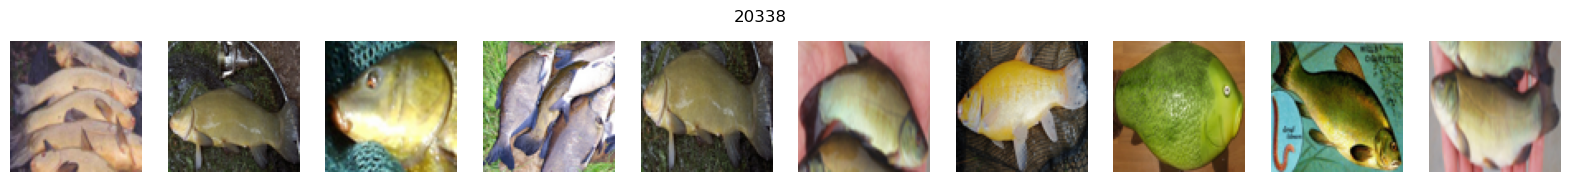

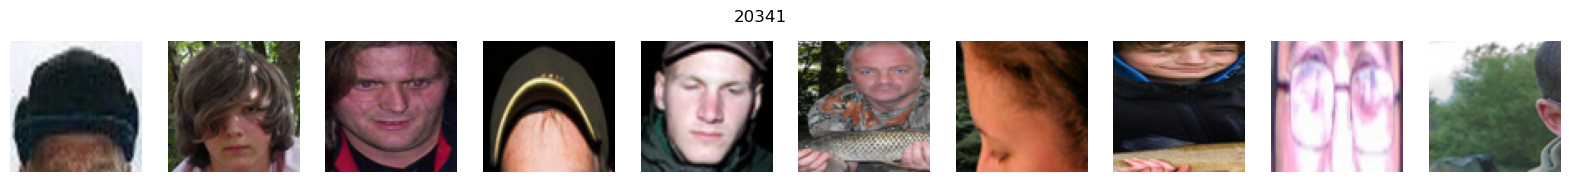

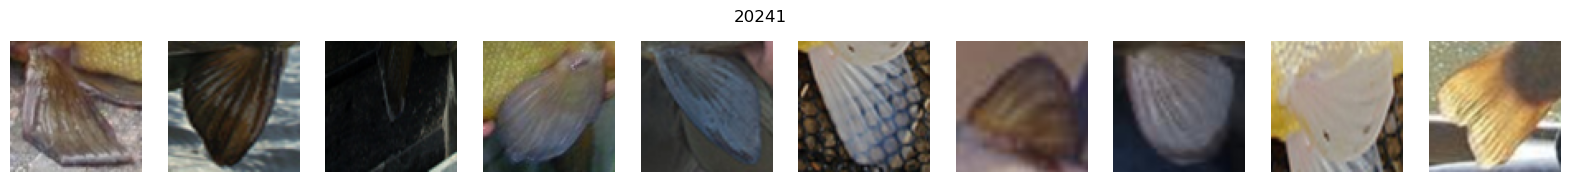

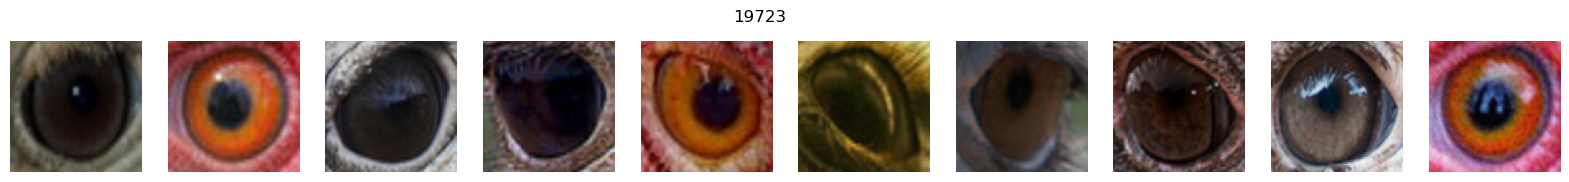

In [52]:
viz_clusters(cluster_ids, cluster_labels, crops_dataset, preview_size=10, shuffle=True)

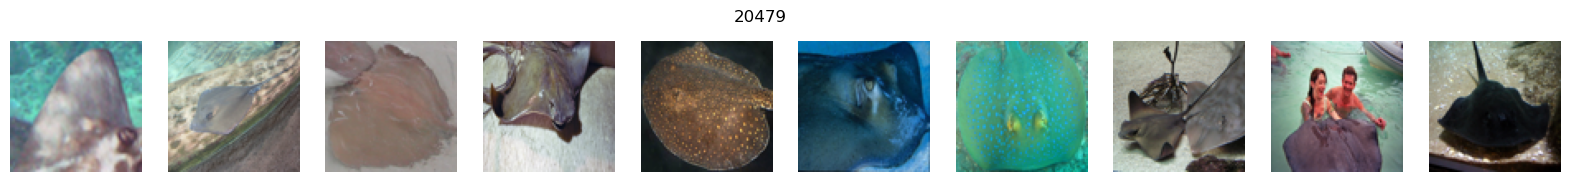

In [232]:
viz_clusters([20479], cluster_labels, crops_dataset, preview_size=10, shuffle=True)

In [238]:
images_of_interest = images_dataset.filter(lambda x: x['label'] == 6, keep_in_memory=True)

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

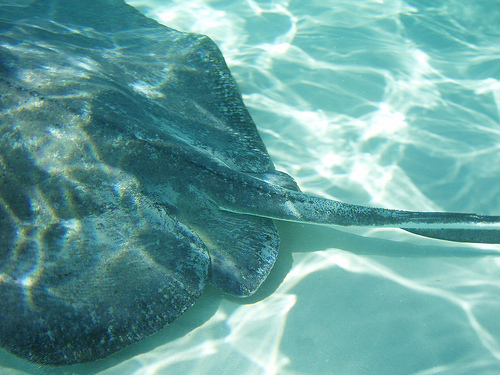

In [256]:
images_of_interest[55]['image']